# Viral Text Classification using Machine Learning
Exploring binary classification for virality prediction - here we use Logistic Regression, Random Forest, and XGBoost.

Can we use machine learning to better understand the propagation of information? Like ecosystems, information also reproduces, has niches, and is subject to selection pressures. When a piece of information on average propagates to more than one person, it tends to spread exponentially, or "goes viral". The spread of information is relevant everywhere, like when an organization is building a brand or spreading awareness of a new product. In this analysis we'll focus on scientific communication happening on twitter Machine Learning communities, to study which information is most likely to spread from one researcher to another.

Two main factors for us to think about are follower counts and niches. Accounts with lots of followers are naturally retweeted more often. In this project we can begin to quantify that relationship more specifically.

Niches are more complicated - the same tweet can go viral in one niche but not others. By specifically looking for "accounts connected to prominent machine-learning researchers" we can make the assumption that these will mostly represent a "machine learning" niche within the social network. This process would be different if we were studying virality in a pop music niche, for instance.

By learning about information propagation, we can gain a deeper insight into how markets work, how company culture forms, how insights propagate across teams, how misinformation spreads, and, generally, how change happens in social networks.

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer


from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [18]:
data = pd.read_csv('data/combined_data.csv', index_col=0)

In [19]:
data

,creation_time,user,tweet,retweets,favorites,followers,lists
0,2022-09-26 20:14:17+00:00,GregL_Intel,I am looking forward to Intel Fellow @brendang...,10,54,4123,41
1,2022-09-26 20:11:39+00:00,GregL_Intel,Open software ecosystems are key to fostering ...,4,26,4123,41
2,2022-09-21 18:48:59+00:00,GregL_Intel,“AI Everywhere” will require optimized hardwar...,11,25,4123,41
3,2022-09-20 18:00:01+00:00,GregL_Intel,Our collaboration with @TU_Muenchen and the It...,2,12,4123,41
4,2022-09-19 22:52:59+00:00,GregL_Intel,"I am looking forward to having @AndrewYNg, fou...",19,85,4123,41
...,...,...,...,...,...,...,...
63028,2020-04-15 16:15:57+00:00,BarryJOGorman,@S_dF speaking of 'daily digital habits' - int...,2,1,909,103
63029,2020-04-15 13:54:53+00:00,BarryJOGorman,@nyike - if 'pushing envelope' - will always m...,1,0,909,103
63030,2021-02-03 18:17:58+00:00,RahulRJB,Even the mighty fall\n#FarmersProstest,1,2,47,0
63031,2022-10-06 06:42:42+00:00,jonsadventures,I've been writing notes for my second year non...,10,62,99,4


### Natural Language Processing
Here we will generate Bag of Words data and load in our other NLP data from the other notebooks. If you haven't run those yet, you will need to to generate their data.

In [32]:
# generating Bag Of Words data
max_doc_frequency = 0.04
min_doc_frequency = 0.004

vectorizer = CountVectorizer(lowercase=True, stop_words={'english'}, ngram_range=(1, 2), max_df=max_doc_frequency, min_df=min_doc_frequency)
docs = data.tweet.tolist()
words = vectorizer.fit_transform(docs)
BOW = pd.DataFrame(words.toarray(), columns=vectorizer.get_feature_names())
BOW = BOW.add_suffix('_BOW')

# Loading Document Embeddings
EMB = pd.read_csv('data/combined_document_embeddings.csv', index_col=0)
EMB = EMB.add_suffix('_EMB')

# Loading Topics
TOP = pd.read_csv('data/topics.csv', index_col=0)
TOP = pd.get_dummies(TOP['topic'], drop_first=True).add_suffix('_TOP') # getting dummy columns

C:\Users\8D\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


If that all worked, we should have three new datasets - BOW, EMB, and TOP.

### Combining and Preparing Data

In [147]:
# Split retweets to binary
data['viral'] = np.where(data['retweets']>50, 1, 0)

# Removing outlier accounts with extreme follower counts
data = data.loc[data['followers'] <= 50000].dropna(axis=1)
data = data.loc[data['followers'] >= 500]

In [148]:
combined_data = data.join(BOW).join(EMB).join(TOP)

In [149]:
# Assigning X and Y Values
X = combined_data.drop(['retweets', 'favorites', 'creation_time', 'user', 'tweet', 'viral'], axis=1)
y = combined_data['viral']

### Train-test-split and oversampling

In [150]:
# Train-test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, stratify=y, random_state=42)
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .1, stratify=y_train, random_state=42)

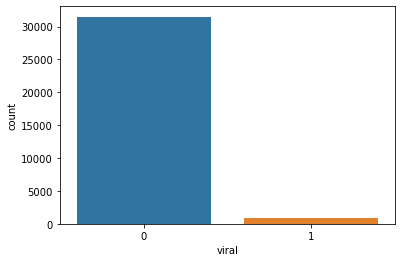

The class imbalance in the dataset is considerable, with a target constituting only 2.7% of the data.


In [151]:
# Illustrating the Class Imbalance
plt.show(sns.countplot(x=data['viral']))
class_imbalance = round(sum(data['viral']) / len(data['viral']), 3) * 100
print(f'The class imbalance in the dataset is considerable, with a target constituting only {round(class_imbalance, 3)}% of the data.')

To address this, we can use SMOTE, which generates additional data representing our target class. Note that we are only oversampling our training data! Oversampling validation sets is a common mistake.

Class Imbalance addresssed with SMOTENC:


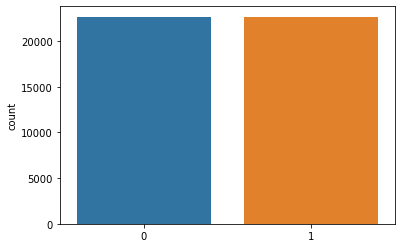

In [152]:
# Balancing class-imbalanced data with SMOTENC
sm = SMOTENC(categorical_features=[98], random_state=42)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train.ravel())
print('Class Imbalance addresssed with SMOTENC:')
sns.countplot(x=y_train_SMOTE);

## Baseline Models
Now we're ready for machine learning - How do the default models perform on our data?

In [153]:
# Instantiate and Fit a Logistic Regression Classifier
log_reg=LogisticRegression()
log_reg.fit(X_train_SMOTE,y_train_SMOTE)

# Accuracy of training and validation sets
print('Training Accuracy: {:.4}%'.format(log_reg.score(X_train_SMOTE, y_train_SMOTE) * 100))
print('Validation accuracy: {:.4}%'.format(log_reg.score(X_val, y_val) * 100))

Training Accuracy: 91.4%
Validation accuracy: 86.81%


In [154]:
# Instantiate and Fit an XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train_SMOTE, y_train_SMOTE)

# Accuracy of training and validation sets
print('Training Accuracy: {:.4}%'.format(XGB.score(X_train_SMOTE, y_train_SMOTE) * 100))
print('Validation accuracy: {:.4}%'.format(XGB.score(X_val, y_val) * 100))

Training Accuracy: 100.0%
Validation accuracy: 96.94%


In [155]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train_SMOTE, y_train_SMOTE)

# Training and validation accuracy score
print('Training Accuracy: {:.4}%'.format(forest.score(X_train_SMOTE, y_train_SMOTE) * 100))
print('Validation accuracy: {:.4}%'.format(forest.score(X_val, y_val) * 100))

Training Accuracy: 100.0%
Validation accuracy: 97.41%


In [156]:
# Comparing all three models
print('LogReg Validation set Accuracy:  {:.4}%'.format(log_reg.score(X_val, y_val) * 100))
print('XGBoost Validation set Accuracy: {:.4}%'.format(XGB.score(X_val, y_val) * 100))
print('Forest Validation set Accuracy:  {:.4}%'.format(forest.score(X_val, y_val) * 100))

log_pred=log_reg.predict(X_val)
XGB_pred=XGB.predict(X_val)
RF_pred=forest.predict(X_val)

print('\nLogistic Regression Report:')
print(classification_report(y_val, log_pred))
print('\nXGBoost Report:')
print(classification_report(y_val, XGB_pred))
print('\nRF Report:')
print(classification_report(y_val, RF_pred))

LogReg Validation set Accuracy:  86.81%
XGBoost Validation set Accuracy: 96.94%
Forest Validation set Accuracy:  97.41%

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      6299
           1       0.06      0.28      0.10       176

    accuracy                           0.87      6475
   macro avg       0.52      0.58      0.52      6475
weighted avg       0.95      0.87      0.91      6475


XGBoost Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6299
           1       0.37      0.17      0.23       176

    accuracy                           0.97      6475
   macro avg       0.67      0.58      0.61      6475
weighted avg       0.96      0.97      0.96      6475


RF Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      6299
           1       0.90      0.05      0.10       176

    

Great - it looks like all of our models are working, with XGBoost in the lead with .23 f1 and 97% accuracy.

In [157]:
print('Baseline Models with Default Parameters:\n')
print('Logistic Regression F1:')
print(f1_score(y_val, log_pred))
print('\nXGB F1:')
print(f1_score(y_val, XGB_pred))
print('\nRF F1:')
print(f1_score(y_val, RF_pred))

Baseline Models with Default Parameters:

Logistic Regression F1:
0.10294117647058823

XGB F1:
0.23255813953488372

RF F1:
0.09677419354838711


We can also think about our model interpretability - here is the feature importance according to our logistic regression model:

In [158]:
# Interpreting our feature importance
coef = log_reg.coef_[0]
logreg_coef = pd.DataFrame(coef, 
             X_train_SMOTE.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)
logreg_coef

,coef
100daysofcode_BOW,3.403214
113_TOP,3.277282
python_BOW,2.688490
machinelearning_BOW,2.246830
innovation_BOW,2.188542
...,...
when_BOW,-1.550819
get_BOW,-1.557380
good_BOW,-1.576978
see_BOW,-1.667257


# Hyperparameter Tuning
Now let's see if we can improve upon our machine learning model baselines with some hyperparameter tuning.

In [159]:
measure = ['accuracy','f1']
optimize = 'f1'

### Logistic Regression Hyperparameter Tuning

In [160]:
# Our hyperparameter grid, with some other options as comments
logreg_params = {
    "C" : [0.01, 0.1, 1],
    'class_weight': ['balanced'],
    "penalty" : ["l1","l2"],
    'solver':['liblinear']
}

# Searching Parameters
grid_logreg = GridSearchCV(log_reg, logreg_params, scoring=measure, refit=optimize, cv=2, n_jobs=1)
grid_logreg.fit(X_train_SMOTE, y_train_SMOTE)

logreg_best_params = grid_logreg.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(logreg_best_params.keys()):
    print('%s: %r' % (param_name, logreg_best_params[param_name]))

Grid Search found the following optimal parameters: 
C: 1
class_weight: 'balanced'
penalty: 'l1'
solver: 'liblinear'


In [259]:
# Comparison to Baseline
Rlogreg_pred=grid_logreg.predict(X_val)
print('Baseline Logistic Regression F1: ' + str(f1_score(y_val, log_pred)))
print('Tuned Logistic Regression F1: ' + str(f1_score(y_val, Rlogreg_pred)))

threshold = .51; predicted_proba = grid_logreg.predict_proba(X_val)
tt_logreg_val_preds = (predicted_proba [:,1] >= threshold).astype('int')

print('Threshold Tuned LogReg F1: ' + str(f1_score(y_val, tt_logreg_val_preds)))

Baseline Logistic Regression F1: 0.10294117647058823
Tuned Logistic Regression F1: 0.23342175066312998
Threshold Tuned LogReg F1: 0.2359249329758713


### XGBoost Hyperparameter Tuning

In [162]:
# Our hyperparameter grid, with some other options as comments

XGB_params = {
    'learning_rate' : [0.3],
    'min_child_weight' : [5],
#     'gamma' : [0.0, 0.1, 0.2 , 0.3, 0.4],
#     'colsample_bytree' : [0.3, 0.4, 0.5 , 0.7],
    'alpha' : [0.01], # L1 regularization
#     'eta': [1, 0.1, 0.01,],
    'eval_metric':['mlogloss'],
    'lambda':[1], # L2 regularization
    'booster' : ['gbtree'],
    'max_depth': [7, None],
    'n_estimators': [120],
#     'subsample': [0.5]
}

# Searching Parameters
grid_XGB = GridSearchCV(XGB, XGB_params, scoring=measure, refit=optimize, cv=2, n_jobs=1)
grid_XGB.fit(X_train_SMOTE, y_train_SMOTE)

XGB_best_parameters = grid_XGB.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(XGB_best_parameters.keys()):
    print('%s: %r' % (param_name, XGB_best_parameters[param_name]))

Grid Search found the following optimal parameters: 
alpha: 0.01
booster: 'gbtree'
eval_metric: 'mlogloss'
lambda: 1
learning_rate: 0.3
max_depth: 7
min_child_weight: 5
n_estimators: 120


In [260]:
# Comparison to Baseline
RXGB_pred=grid_XGB.predict(X_val)
print('Baseline XGBoost F1: ' + str(f1_score(y_val, XGB_pred)))
print('Tuned XGB F1: ' + str(f1_score(y_val, RXGB_pred)))

threshold = .175; predicted_proba = grid_XGB.predict_proba(X_val)
tt_xgb_val_preds = (predicted_proba [:,1] >= threshold).astype('int')

print('Threshold Tuned XGB F1: ' + str(f1_score(y_val, tt_xgb_val_preds)))

Baseline XGBoost F1: 0.23255813953488372
Tuned XGB F1: 0.22907488986784144
Threshold Tuned XGB F1: 0.2623906705539359


### Random Forest Hyperparameter Tuning

In [164]:
# Our hyperparameter grid, with some other options as comments
rf_params = {
    'bootstrap' : [False],
    'class_weight' : ['balanced'], # 'balanced_subsample',
    'criterion' : ['entropy'], # 'gini', 
    'max_features' : ['auto'],
    'max_depth' : [50],
    'n_estimators' : [120]
}

# Searching parameters
grid_rf = GridSearchCV(forest, rf_params, scoring=measure, refit=optimize, cv=2, n_jobs=1)
grid_rf.fit(X_train_SMOTE, y_train_SMOTE)

rf_best_params = grid_rf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(rf_best_params.keys()):
    print('%s: %r' % (param_name, rf_best_params[param_name]))

C:\Users\8D\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\8D\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\8D\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Grid Search found the following optimal parameters: 
bootstrap: False
class_weight: 'balanced'
criterion: 'entropy'
max_depth: 50
max_features: 'auto'
n_estimators: 120


In [261]:
# Comparison to Baseline
RRF_pred=grid_rf.predict(X_val)
print('Baseline Random Forest F1: ' + str(f1_score(y_val, RF_pred)))
print('Tuned Random Forest F1: ' + str(f1_score(y_val, RRF_pred)))

threshold = .244; predicted_proba = grid_rf.predict_proba(X_val)
tt_rf_val_preds = (predicted_proba [:,1] >= threshold).astype('int')

print('Threshold Tuned Random Forest F1: ' + str(f1_score(y_val, tt_rf_val_preds)))

Baseline Random Forest F1: 0.09677419354838711
Tuned Random Forest F1: 0.1164021164021164
Threshold Tuned Random Forest F1: 0.30640668523676884


# Tuned Model Analysis

In [263]:
print('\nTuned Logistic Regression Report:')
print(classification_report(y_val, tt_logreg_val_preds))
print('\nTuned XGBoost Report:')
print(classification_report(y_val, tt_xgb_val_preds))
print('\nTuned RF Report:')
print(classification_report(y_val, tt_rf_val_preds))


Tuned Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6299
           1       0.22      0.25      0.24       176

    accuracy                           0.96      6475
   macro avg       0.60      0.61      0.61      6475
weighted avg       0.96      0.96      0.96      6475


Tuned XGBoost Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6299
           1       0.27      0.26      0.26       176

    accuracy                           0.96      6475
   macro avg       0.62      0.62      0.62      6475
weighted avg       0.96      0.96      0.96      6475


Tuned RF Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6299
           1       0.30      0.31      0.31       176

    accuracy                           0.96      6475
   macro avg       0.64      0.65      0.64      647

We're starting to see some much better performance from our random forest model - maybe we will use that for our final model?

In [264]:
# Accuracy Scores
print('Tuned Accuracy Scores compared to Baseline:\n')
print('LogReg Validation Accuracy:         {:.4}%'.format(log_reg.score(X_val, y_val) * 100))
print('Tuned LogReg Validation Accuracy:   {:.4}%'.format(grid_logreg.best_score_*100))
print()
print('XGBoost Validation Accuracy:        {:.4}%'.format(XGB.score(X_val, y_val) * 100))
print('Tuned XGBoost Validation Accuracy:  {:.4}%'.format(grid_XGB.best_score_*100))
print()
print('Forest Validation Accuracy:         {:.4}%'.format(forest.score(X_val, y_val) * 100))
print('Tuned Forest Validation Accuracy:   {:.4}%'.format(grid_rf.best_score_*100))

Tuned Accuracy Scores compared to Baseline:

LogReg Validation Accuracy:         86.81%
Tuned LogReg Validation Accuracy:   96.72%

XGBoost Validation Accuracy:        96.94%
Tuned XGBoost Validation Accuracy:  99.4%

Forest Validation Accuracy:         97.41%
Tuned Forest Validation Accuracy:   99.87%


We can see that our validation accuracies have improved considerably on all counts, with our Random Forest model leading the batch. How do our ROC Curves look?

Logistic Regression AUC: 71.61%
XGBoost AUC:    80.77%
Random Forest AUC:     81.56%


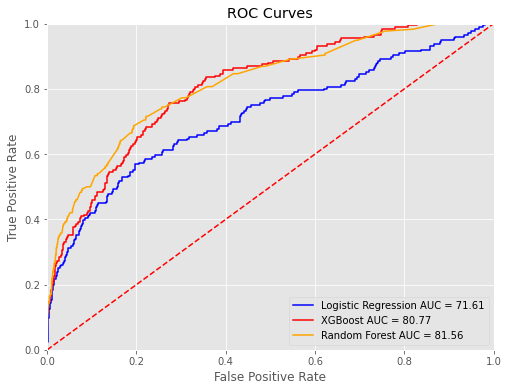

In [268]:
# ROC Curves for Tuned Sets
plt.figure(figsize=(8, 6))
plt.style.use('ggplot')

logreg_fp, logreg_tp, thresholds=roc_curve(y_val, grid_logreg.decision_function(X_val), pos_label=1)
logreg_AUC=auc(logreg_fp, logreg_tp)*100
print(f'Logistic Regression AUC: {round(logreg_AUC, 2)}%')
plt.plot(logreg_fp, logreg_tp, color='blue',label = 'Logistic Regression AUC = %0.2f' % logreg_AUC)

XGB_fp, XGB_tp, thresholds=roc_curve(y_val, grid_XGB.predict_proba(X_val)[:,1], pos_label=1)
XGB_AUC=auc(XGB_fp, XGB_tp)*100
print(f'XGBoost AUC:    {round(XGB_AUC, 2)}%')
plt.plot(XGB_fp, XGB_tp, color='red',label = 'XGBoost AUC = %0.2f' % XGB_AUC)

RF_fp, RF_tp, thresholds=roc_curve(y_val, grid_rf.predict_proba(X_val)[:,1], pos_label=1)
RF_AUC=auc(RF_fp, RF_tp)*100
print(f'Random Forest AUC:     {round(RF_AUC, 2)}%')
plt.plot(RF_fp, RF_tp, color='orange',label = 'Random Forest AUC = %0.2f' % RF_AUC)

plt.title('ROC Curves')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We see that Random Forest is in the lead for AUC, closely followed by XGB. Logistic Regression is starting to lag on all fronts.

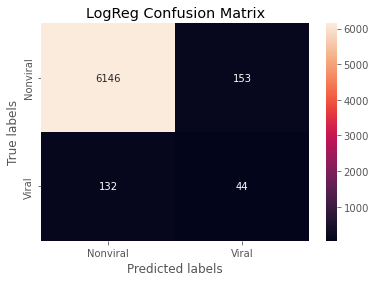

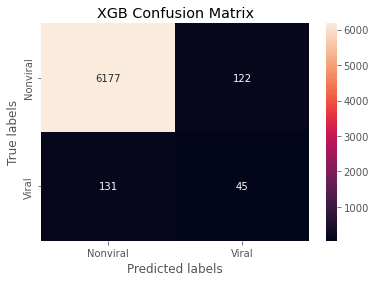

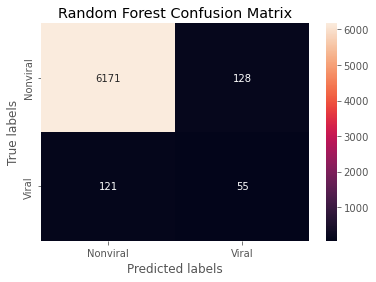

In [265]:
# Tuned Confusion Matrices
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_val, tt_logreg_val_preds), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); ax.set_title('LogReg Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Nonviral', 'Viral']); ax.yaxis.set_ticklabels(['Nonviral', 'Viral']);
plt.show(ax)

ax = plt.subplot()
sns.heatmap(confusion_matrix(y_val, tt_xgb_val_preds), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); ax.set_title('XGB Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Nonviral', 'Viral']); ax.yaxis.set_ticklabels(['Nonviral', 'Viral']);
plt.show(ax)

ax = plt.subplot()
sns.heatmap(confusion_matrix(y_val, tt_rf_val_preds), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); ax.set_title('Random Forest Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Nonviral', 'Viral']); ax.yaxis.set_ticklabels(['Nonviral', 'Viral']);
plt.show(ax)

## Final Model Selection
We will use our Random Forest model as our final, as it's showing the best f1 scores - f1 is probably the best metric for how imbalanced our data is.

Threshold Tuned Random Forest F1: 0.2647058823529411

Tuned Random Forest Report on Test Data:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2520
           1       0.27      0.26      0.26        70

    accuracy                           0.96      2590
   macro avg       0.63      0.62      0.62      2590
weighted avg       0.96      0.96      0.96      2590



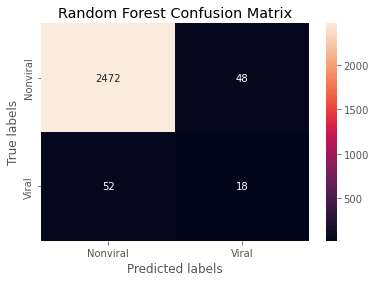

In [269]:
threshold = .244; predicted_proba = grid_rf.predict_proba(X_test)
tt_rf_test_preds = (predicted_proba [:,1] >= threshold).astype('int')

print('Threshold Tuned Random Forest F1: ' + str(f1_score(y_test, tt_rf_test_preds)))

print('\nTuned Random Forest Report on Test Data:')
print(classification_report(y_test, tt_rf_test_preds))

ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, tt_rf_test_preds), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); ax.set_title('Random Forest Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Nonviral', 'Viral']); ax.yaxis.set_ticklabels(['Nonviral', 'Viral']);
plt.show(ax)

# Findings and Conclusions
Our final model had an accuracy of 96%, with an f1 score of 0.26! Building this predictive capability into copywriting, social media management, or communications dashboards could be a useful reference. Communication on the whole is complicated and very high dimensional, but the existence of our relatively simple models consistently describing some amount of information propagation rate means that there is some feasibility here.

Virality is a hard thing to predict, partly because, like the stock market, once people find a strategy that consistently works, it influences the information landscape and eventually stops working. This evolving information landscape leads to the need for constantly shifting communication strategies. This means any model trained on language will probably decay in accuracy, depending on the rate of cultural change. This has some interesting ramifications, and means you can't just predict what has worked, but also what will work at the time of posting. It doesn't currently seem possible to have a predictive model with anywhere near the level of resolution needed to predict future trends, but it may be an interesting experiment if you have access to enough data.

More work was done that was cut from this notebook - All of the deep learning was removed, as in each case they consistently underperformed our other options. For cleanliness I moved their coding blocks into a scratch-code notebook which I can share on request.

### Next Steps
The next steps for predicting virality fall into a few categories:
- integrating with users, for example through a dashboard where people can input text to get a virality score
- Improving the quality of our predictive models, either through collecting more data or more sophisticated NLP
- mapping out our graph of actors and ties and interpreting the predictive power of the network itself
- studying the structure of various feeds and interpreting how information is selected and shown
- finding the right way to ensemble our current predictive power

Areas that are not likely to yield further gains:
- machine learning algorithms don't seem likely to see significant improvement on the current data through hyperparameter tuning
- Deep learning still seems to struggle with tabular data, and we still need something better than TabNet for this kind of task


# The End :)

For more information or contract work, reach out to me at:
- blakemcme@gmail.com
- github.com/thegrandblooms
- linkedin.com/in/blakemcme